In [1]:
import cv2
import numpy as np
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage import io, metrics

In [38]:
# img = cv2.cvtColor(cv2.imread('../uploads/lenna.png'), cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(cv2.imread('d:\Baitap\SubjectFinished\TNV\duoihinhbat chu\co thu.jpg'), cv2.COLOR_BGR2RGB)

In [39]:
def toBlocks(img, xLen, yLen, h, w):
    blocks = np.zeros((yLen,xLen,h,w,3),dtype=np.int16)
    for y in range(yLen):
        for x in range(xLen):
            blocks[y][x]=img[y*h:(y+1)*h,x*w:(x+1)*w]
    return np.array(blocks)

def blocks2img(blocks, xLen, yLen, h, w):
    W   = xLen*w
    H   = yLen*h
    img = np.zeros((H,W,3))
    for y in range(yLen):
        for x in range(xLen):
            img[y*h:y*h+h,x*w:x*w+w]=blocks[y][x]
    return img

def dctOrDedctAllBlocks(blocks, yLen, xLen, h, w,type="dct"):
    f=dct if type=="dct" else idct
    dedctBlocks = np.zeros((yLen,xLen,h,w,3))
    for y in range(yLen):
        for x in range(xLen):
            d = np.zeros((h,w,3))
            for i in range(3):
                block=blocks[y][x][:,:,i]
                d[:,:,i]=f(f(block.T, norm = 'ortho').T, norm = 'ortho')
                if (type!="dct"):
                    d=d.round().astype(np.int16)
            dedctBlocks[y][x]=d
    return dedctBlocks

In [40]:
rows, cols, channels = img.shape
mean = 0
std_dev = 15 # Điều chỉnh độ lớn của nhiễu Gaussian
noise = np.random.normal(mean, std_dev, (rows, cols, channels))
# Thêm nhiễu vào ảnh
noisy_image = np.clip(img + noise, 0, 255).astype(np.uint8)

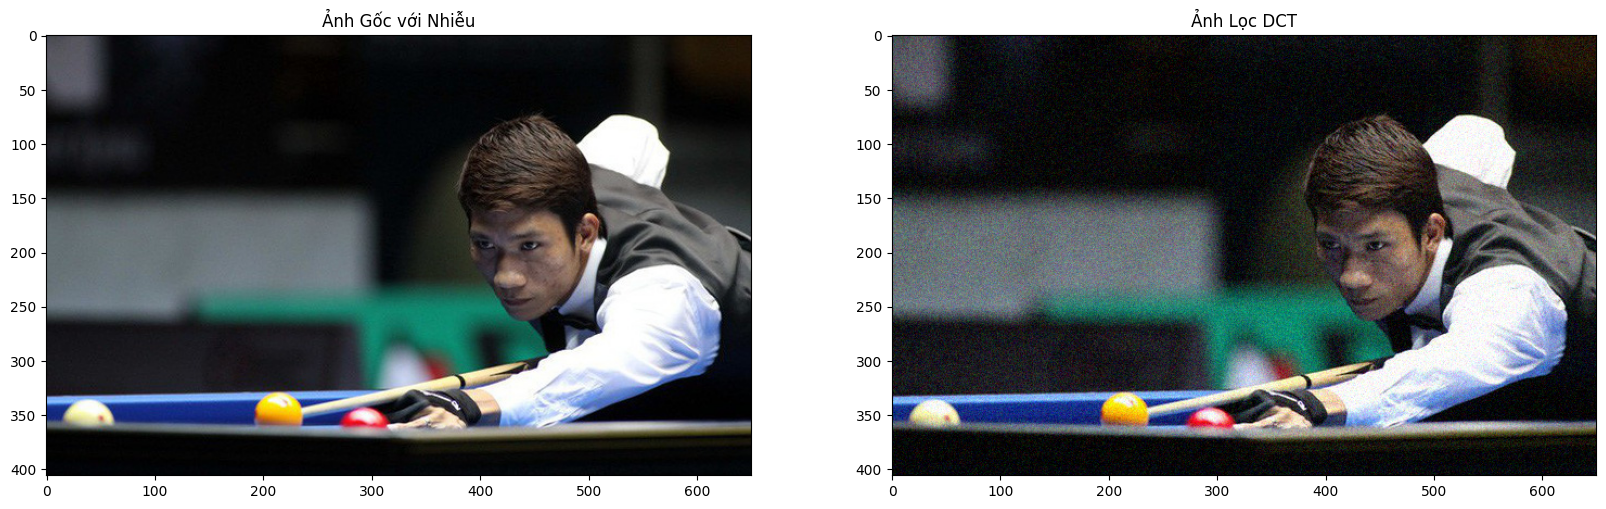

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(20, 20))
axes[0].imshow(img)
axes[0].set_title('Ảnh Gốc với Nhiễu')
axes[1].imshow(noisy_image)
axes[1].set_title('Ảnh Lọc DCT')
plt.show()

In [42]:
DCTbasis3x3 = np.array([
    [   0.5773502588272094726562500000000000000000,
        0.5773502588272094726562500000000000000000,
        0.5773502588272094726562500000000000000000,     ],
    [  0.7071067690849304199218750000000000000000,
      0.0000000000000000000000000000000000000000,
      -0.7071067690849304199218750000000000000000, ],
    [
        0.4082483053207397460937500000000000000000,
        -0.8164966106414794921875000000000000000000,
        0.4082483053207397460937500000000000000000      ]
])

def ColorTransform(img, DCTbasis3x3, flag=1):
    image_flat = img.reshape(-1, 3)
    if flag == 1:
        transformed_image_flat = np.dot(image_flat, DCTbasis3x3.T)
    else:
        transformed_image_flat = np.dot(image_flat, DCTbasis3x3)
    transformed_image_flat = transformed_image_flat.reshape(img.shape)
    return transformed_image_flat

In [43]:
w = 16 #modify it if you want, maximal 8 due to default quantization table is 8*8
h = w
xLen = img.shape[1]//w
yLen = img.shape[0]//h
image_trans = ColorTransform(noisy_image, DCTbasis3x3, flag=1)
blocks_denosing = toBlocks(image_trans, xLen, yLen, h, w)
dct_blocks_denoising = dct(dct(blocks_denosing, axis=2, norm='ortho'), axis=3, norm='ortho')
threshold = std_dev * 3
dct_blocks_filtered = np.where(np.abs(dct_blocks_denoising) < threshold, 0, dct_blocks_denoising)
filtered_blocks = idct(idct(dct_blocks_filtered, axis=2, norm='ortho'), axis=3, norm='ortho')
newImg=blocks2img(filtered_blocks, xLen, yLen, h, w)
newImg = ColorTransform(newImg, DCTbasis3x3, flag=-1)
newImg = np.clip(newImg, 0, 255).astype(np.uint8)

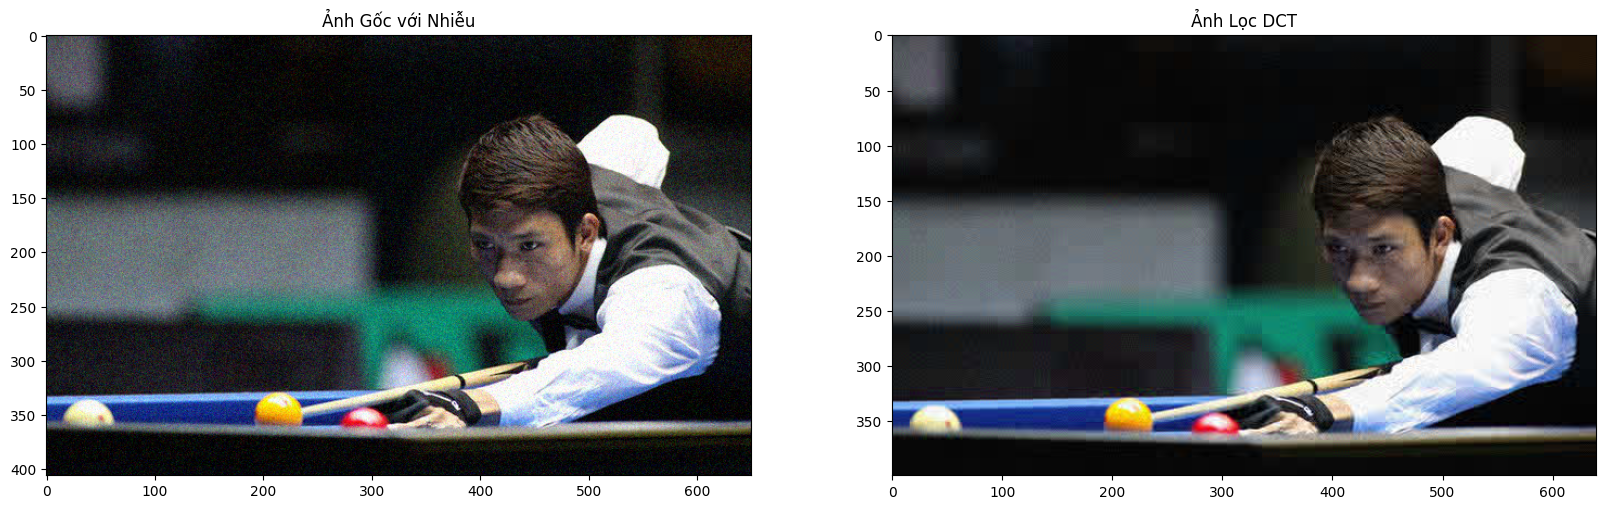

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(20, 20))
axes[0].imshow(noisy_image)
axes[0].set_title('Ảnh Gốc với Nhiễu')
axes[1].imshow(newImg)
axes[1].set_title('Ảnh Lọc DCT')
plt.show()

In [49]:
img.shape[:-1]

(1920, 2560)

In [45]:
def get_gaussian(size_patch, num_class, sigma_scale = 1./8):
    patch_size = [size_patch, size_patch]
    tmp = np.zeros(patch_size)
    center_coords = [i // 2 for i in patch_size]
    sigmas = [i * sigma_scale for i in patch_size]
    tmp[tuple(center_coords)] = 1
    gaussian_importance_map = gaussian_filter(tmp, sigmas, 0, mode='constant', cval=0)
    gaussian_importance_map = gaussian_importance_map / np.max(gaussian_importance_map) * 1
    gaussian_importance_map = gaussian_importance_map.astype(np.float32)

    # gaussian_importance_map cannot be 0, otherwise we may end up with nans!
    gaussian_importance_map[gaussian_importance_map == 0] = np.min(
        gaussian_importance_map[gaussian_importance_map != 0])

    result = np.zeros((*gaussian_importance_map.shape, num_class))
    for i in range(num_class):
        result[..., i] = gaussian_importance_map

    return result

def sliding_window_denoising_gaussian(img, size_patch, stride, threshold, sigma_scale=1./8):
    h, w = img.shape[0:2]
    w_h, w_w = size_patch,size_patch
    s_h, s_w = stride, stride
    result = np.zeros((*img.shape[:-1], 3), dtype='float64')
    overlap = np.zeros((*img.shape[:-1], 3), dtype='float64')
    starting_points = [(x, y)  for x in set( list(range(0, h - w_h, s_h)) + [h - w_h] ) 
                                for y in set( list(range(0, w - w_w, s_w)) + [w - w_w] )]
    gaussian_weight = get_gaussian(size_patch, num_class=3,sigma_scale=sigma_scale)
    patches = np.empty((len(starting_points), w_h, w_w, 3), dtype='float64')
    for i, (x, y) in enumerate(starting_points):
        patches[i] = img[x:x + w_h, y:y + w_w, :]

    patches_dct = dct(dct(patches, axis=1, norm='ortho'), axis=2, norm='ortho')
    patches_th = np.where(patches_dct < threshold, 0, patches_dct)
    patches_th = idct(idct(patches_th, axis=1, norm='ortho'), axis=2, norm='ortho')
        
    for i in range(len(patches)):
        x, y = starting_points[i]
        result[x:x + w_h, y:y + w_w, :] += patches_th[i] * gaussian_weight
        overlap[x:x + w_h, y:y + w_w, :] += gaussian_weight

    assert np.sum(overlap == 0.) == 0, "Sliding window does not cover all volume"

    return np.clip(result / overlap, 0, 255).astype(np.uint8)

def sliding_window_denoising(img, size_patch, stride, threshold):
    h, w = img.shape[0:2]
    w_h, w_w = size_patch,size_patch
    s_h, s_w = stride, stride
    result = np.zeros((*img.shape[:-1], 3), dtype='float64')
    overlap = np.zeros((*img.shape[:-1], 3), dtype='float64')
    starting_points = [(x, y)  for x in set( list(range(0, h - w_h, s_h)) + [h - w_h] ) 
                                for y in set( list(range(0, w - w_w, s_w)) + [w - w_w] )]
    patches = np.empty((len(starting_points), w_h, w_w, 3), dtype='float64')
    for i, (x, y) in enumerate(starting_points):
        patches[i] = img[x:x + w_h, y:y + w_w, :]

    patches_dct = dct(dct(patches, axis=1, norm='ortho'), axis=2, norm='ortho')
    patches_th = np.where(patches_dct < threshold, 0, patches_dct)
    patches_th = idct(idct(patches_th, axis=1, norm='ortho'), axis=2, norm='ortho')
        
    for i in range(len(patches)):
        x, y = starting_points[i]
        result[x:x + w_h, y:y + w_w, :] += patches_th[i]
        overlap[x:x + w_h, y:y + w_w, :] += 1

    assert np.sum(overlap == 0.) == 0, "Sliding window does not cover all volume"

    return np.clip(result / overlap, 0, 255).astype(np.uint8)

In [9]:
w = 16 #modify it if you want, maximal 8 due to default quantization table is 8*8
h = w
xLen = img.shape[1]//w
yLen = img.shape[0]//h
blocks_denosing = toBlocks(noisy_image, xLen, yLen, h, w)
dct_blocks_denoising = dct(dct(blocks_denosing, axis=2, norm='ortho'), axis=3, norm='ortho')
threshold = std_dev * 3
dct_blocks_filtered = np.where(np.abs(dct_blocks_denoising) < threshold, 0, dct_blocks_denoising)
filtered_blocks = idct(idct(dct_blocks_filtered, axis=2, norm='ortho'), axis=3, norm='ortho')
newImg2 =blocks2img(filtered_blocks, xLen, yLen, h, w)
newImg2 = np.clip(newImg2, 0, 255).astype(np.uint8)

In [46]:
newImg3 = sliding_window_denoising(noisy_image, 8, 1, std_dev * 2)

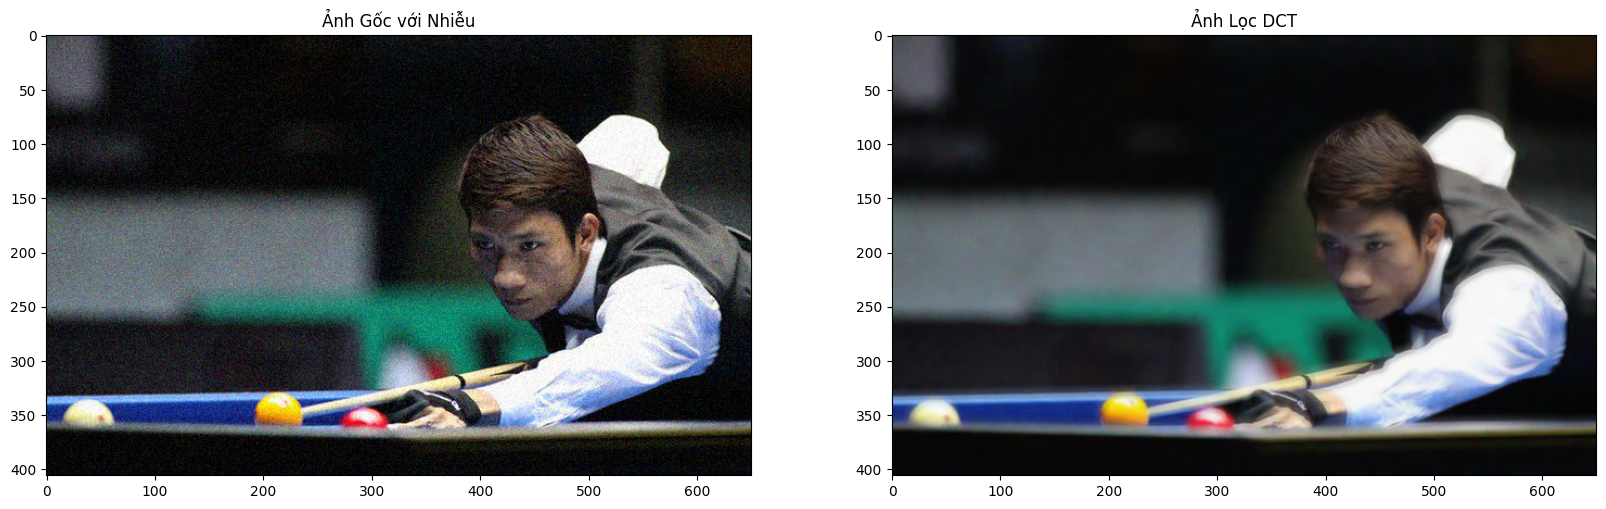

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(20, 20))
axes[0].imshow(noisy_image)
axes[0].set_title('Ảnh Gốc với Nhiễu')
axes[1].imshow(newImg3)
axes[1].set_title('Ảnh Lọc DCT')
plt.show()

In [26]:
# newImg3 = sliding_window_denoising_gaussian(noisy_image, 8, 8, std_dev * 2,1./4)
# fig, axes = plt.subplots(1, 2, figsize=(20, 20))
# axes[0].imshow(noisy_image)
# axes[0].set_title('Ảnh Gốc với Nhiễu')
# axes[1].imshow(newImg3)
# axes[1].set_title('Ảnh Lọc DCT')
# plt.show()

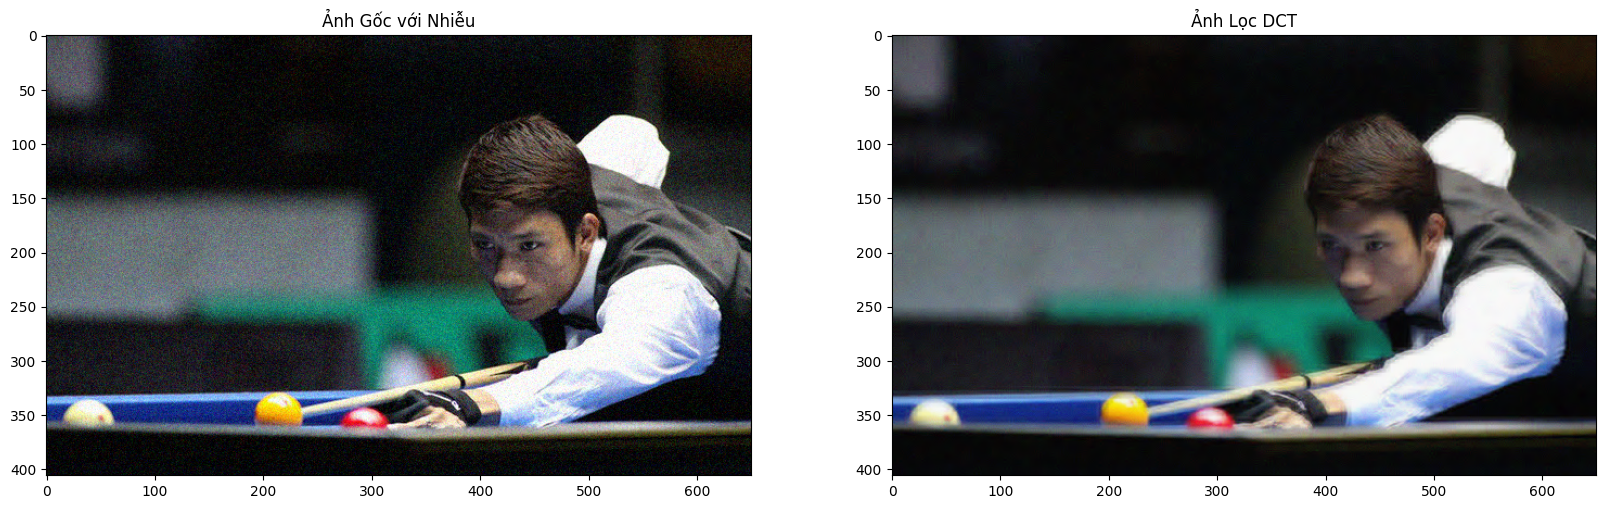

In [48]:
# 8, 4, std_dev * 2,1./4
newImg4 = sliding_window_denoising_gaussian(noisy_image, 8, 4, std_dev * 2, 1./4)
fig, axes = plt.subplots(1, 2, figsize=(20, 20))
axes[0].imshow(noisy_image)
axes[0].set_title('Ảnh Gốc với Nhiễu')
axes[1].imshow(newImg4)
axes[1].set_title('Ảnh Lọc DCT')
plt.show()

In [18]:
print("PSNR: ", metrics.peak_signal_noise_ratio(img, noisy_image))
print("MSE: ", metrics.mean_squared_error(img, noisy_image))
print("SSIM: ", metrics.structural_similarity(img, noisy_image,win_size=3))

PSNR:  13.497900638626714
MSE:  2905.9644495646157
SSIM:  0.49306564716494516


In [19]:
print("PSNR: ",metrics.peak_signal_noise_ratio(img, newImg))
print("MSE: ", metrics.mean_squared_error(img, newImg))
print("SSIM: ", metrics.structural_similarity(img, newImg,win_size=3))

PSNR:  24.132525164495814
MSE:  251.0890909830729
SSIM:  0.9264719246237693


In [20]:
print("PSNR: ",metrics.peak_signal_noise_ratio(img, newImg2))
print("MSE: ", metrics.mean_squared_error(img, newImg2))
print("SSIM: ", metrics.structural_similarity(img, newImg2,win_size=3))

PSNR:  23.318733121988235
MSE:  302.83568445841473
SSIM:  0.9149751856330579


In [49]:
print("PSNR: ",metrics.peak_signal_noise_ratio(img, newImg3))
print("MSE: ", metrics.mean_squared_error(img, newImg3))
print("SSIM: ", metrics.structural_similarity(img, newImg3,win_size=3))

PSNR:  28.93741437439492
MSE:  83.04986358469117
SSIM:  0.8777695032300993


In [50]:
print("PSNR: ",metrics.peak_signal_noise_ratio(img, newImg4))
print("MSE: ", metrics.mean_squared_error(img, newImg4))
print("SSIM: ", metrics.structural_similarity(img, newImg4,win_size=3))

PSNR:  28.522970950296624
MSE:  91.3657168119237
SSIM:  0.8438897794723337
